PUTTING IT ALL TOGETHER

In [25]:
import torch
from torch import nn
import matplotlib.pyplot as plt


torch.__version__

'2.0.0'

DATA
Create Device agnostic code

In [26]:
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device:{device}")


Using device:cuda


In [27]:
#Create some data using the linear regression formula of y= weight x = bias

weight = 0.7
bias = 0.3

#Create range values

start = 0
end = 1

step =0.02

#Create X and y (features and labels)

X = torch.arange(start,end,step).unsqueeze(dim=1)

y = weight*X + bias

X[:10] , y[:10]




(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [28]:
#Split data

train_split = int(0.8*len(X))

X_train,y_train = X[:train_split],y[:train_split]

X_test,y_test = X[train_split:],y[train_split:]

len(X_train),len(y_train),len(X_test),len(y_test)


(40, 40, 10, 10)

In [29]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
    plt.figure(figsize=(10,7))

    #plot training data in blue
    plt.scatter(train_data,train_labels,c="b",s=4,label="Training data")
    #plot testing data in green
    plt.scatter(test_data,test_labels,c="g",s=4,label="Testing Data")
    #Are there predictions?
    if predictions is not None:
        #plot predicitions if they exist
        plt.scatter(test_data,predictions,c="r",label="Predictions")

    #show the legend
    plt.legend(prop={"size": 14})

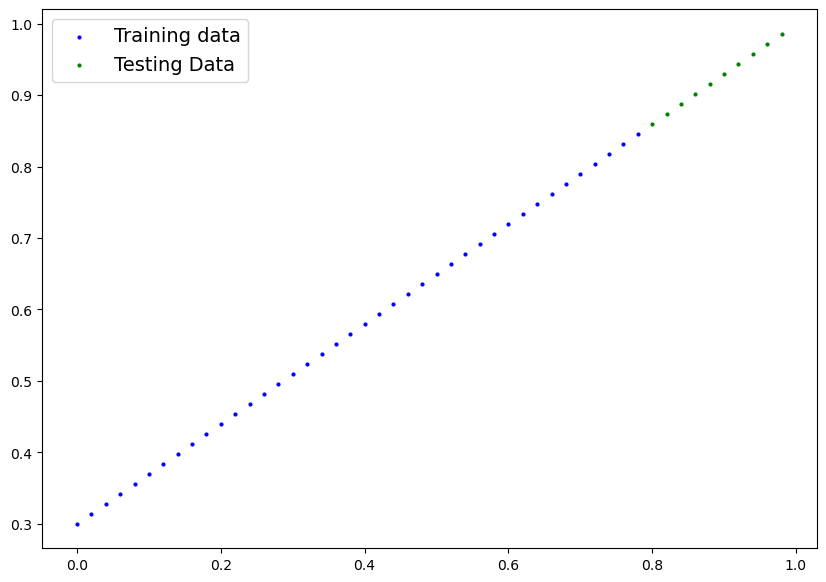

In [30]:
#Plot the data
plot_predictions(X_train,y_train,X_test,y_test)

In [31]:
#Building a PyTorch model

class LinearRegressionModel_2(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        #using nn.Linear()
        self.linear_layer= nn.Linear(in_features=1,
                                     out_features=1)
        

    def forward(self,x:torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)


torch.manual_seed(42)
model_1=LinearRegressionModel_2()

#Create a Loss function
fn_loss=nn.L1Loss()

#Setup Optimizer
optimizer=torch.optim.SGD(params=model_1.parameters(),lr=0.01)

model_1,fn_loss,optimizer,model_1.state_dict()

(LinearRegressionModel_2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 L1Loss(),
 SGD (
 Parameter Group 0
     dampening: 0
     differentiable: False
     foreach: None
     lr: 0.01
     maximize: False
     momentum: 0
     nesterov: False
     weight_decay: 0
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [32]:
next(model_1.parameters()).device

device(type='cpu')

In [33]:
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

In [34]:
torch.manual_seed(42)
#Trainig part
epochs=1000

#Put data into target device (device agnostic code for data)

X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    model_1.train()

    y_pred=model_1(X_train)

    loss=fn_loss(y_pred,y_train)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_1.eval()

    with torch.inference_mode():
        test_pred=model_1(X_test)

        test_loss=fn_loss(test_pred,y_test)

    if epoch % 100 == 0:
        print(f"Epoch:{epoch} | Loss:{loss} | Test loss:{test_loss}")

Epoch:0 | Loss:0.5551779866218567 | Test loss:0.5739762187004089
Epoch:100 | Loss:0.006215683650225401 | Test loss:0.014086711220443249
Epoch:200 | Loss:0.0012645035749301314 | Test loss:0.013801801018416882
Epoch:300 | Loss:0.0012645035749301314 | Test loss:0.013801801018416882
Epoch:400 | Loss:0.0012645035749301314 | Test loss:0.013801801018416882
Epoch:500 | Loss:0.0012645035749301314 | Test loss:0.013801801018416882
Epoch:600 | Loss:0.0012645035749301314 | Test loss:0.013801801018416882
Epoch:700 | Loss:0.0012645035749301314 | Test loss:0.013801801018416882
Epoch:800 | Loss:0.0012645035749301314 | Test loss:0.013801801018416882
Epoch:900 | Loss:0.0012645035749301314 | Test loss:0.013801801018416882


In [35]:
model_1.state_dict(),weight,bias

(OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
              ('linear_layer.bias', tensor([0.3025], device='cuda:0'))]),
 0.7,
 0.3)

In [36]:
model_1.eval()

#Make predictions

with torch.inference_mode():
    y_preds=model_1(X_test)

y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')

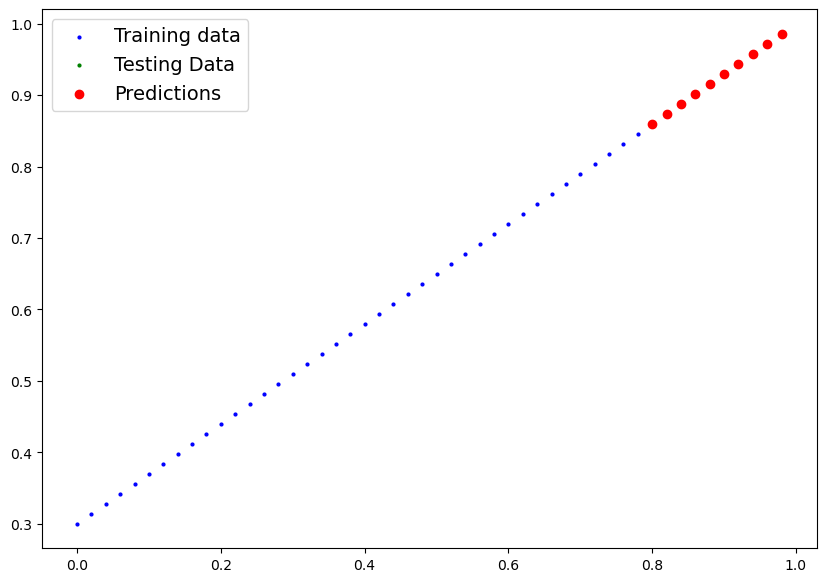

In [37]:
plot_predictions(predictions=y_preds.cpu())

In [39]:
from pathlib import Path
#1. Create models directory

MODEL_PATH= Path("models")

MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to: { MODEL_SAVE_PATH}")

torch.save(obj=model_1.state_dict(),f=MODEL_SAVE_PATH)

Saving model to: models\01_pytorch_workflow_model_1.pth


In [40]:
#Load model

loaded_model_1=LinearRegressionModel_2()
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))
loaded_model_1.to(device)


LinearRegressionModel_2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [41]:
next(loaded_model_1.parameters()).device

device(type='cuda', index=0)

In [43]:
loaded_model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

In [44]:
#Evaluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
    loaded_model_1_preds=loaded_model_1(X_test)
y_preds==loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')